In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk", rc={"figure.figsize": (10, 10)})

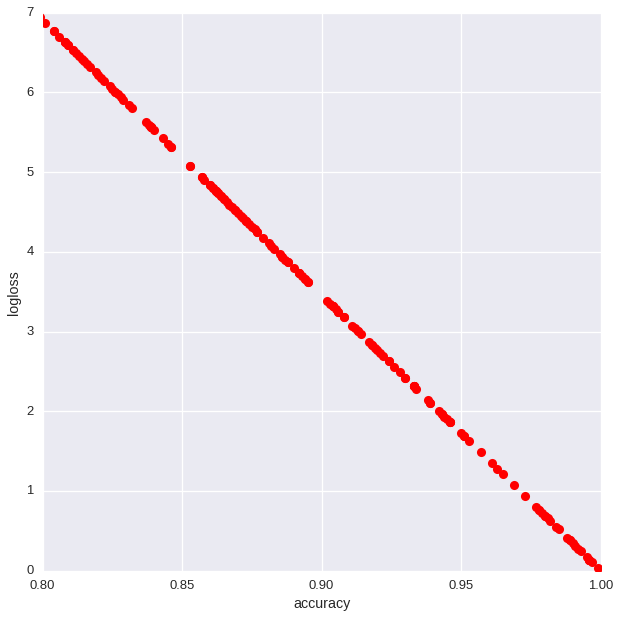

In [2]:
# просто график зависимости logloss от accuracy на наборах случайных данных
# не имеет отношения к тому, что выше или ниже

from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

larray, aarray = [], []
ASIZE = 1000

for i in range(1000):
    #y = np.random.randint(0, 2, (ASIZE))
    #out = np.random.randint(0, 2, (ASIZE))
    
    k = np.random.randint(0, ASIZE)
    y = np.zeros((ASIZE))
    out = np.append(np.zeros(k), np.ones(ASIZE-k))
    
    ll = log_loss(y, out, labels = (0, 1))
    accuracy = np.mean(np.equal(y, out).astype(int))
    
    larray.append(ll)
    aarray.append(accuracy)

plt.plot(aarray, larray, 'ro')
plt.axis([0.8, 1, 0, 7])
plt.xlabel('accuracy')
plt.ylabel('logloss')
#plt.show()

In [3]:
# для себя, чтобы не забывать

all_params = ["maxPlayerLevel",
              "numberOfAttemptedLevels",
              "attemptsOnTheHighestLevel",
              "totalNumOfAttempts",
              "averageNumOfTurnsPerCompletedLevel",
              "doReturnOnLowerLevels",
              "numberOfBoostersUsed",
              "fractionOfUsefullBoosters",
              "totalScore",
              "totalBonusScore",
              "totalStarsCount",
              "numberOfDaysActuallyPlayed",
]

In [4]:
# оригинальный трейнсет
x_train_original = pd.read_csv("data/x_train.csv", delimiter=";", dtype=np.float32)

# оригинальные ответы к трейнсету
y_train_original = pd.read_csv("data/y_train.csv", delimiter=";", header=None,
                      names=["returned"], dtype=np.float32)

# оригинальный тестсет
x_test_original = pd.read_csv("data/x_test.csv", delimiter=";", dtype=np.float32)

# датафрейм из оригинального трейнсета с ответами в колонке returned
x_y_train_original = pd.concat([x_train_original, y_train_original], axis=1)

# датафрейм из оригинальных трейнсетов и тестсетов без ответов
x_train_test_original = pd.concat([x_train_original, x_test_original], axis=0, ignore_index=True)

# датафрейм из оригинальных трейнсетов и тестсетов с ответами для трейна и NaN для теста
x_y_train_test_original = pd.concat([x_train_test_original, y_train_original], axis=1)

# далее мы будем работать с одной таблицей со всеми мать ее данными x_y_train_test_original
# и искренне надеяться что правильно ее сгенерили
# переназовем ее xytt

xytt = x_y_train_test_original

# а также заведем таблицу, куда будем дописывать наши идиотские новые колонки, xytt Extended

xytte = xytt.copy()

In [5]:
# сначала херанем функцию norm, которая нормализует датафрейм или колонку
norm = lambda x: (x - x.mean())/x.std()

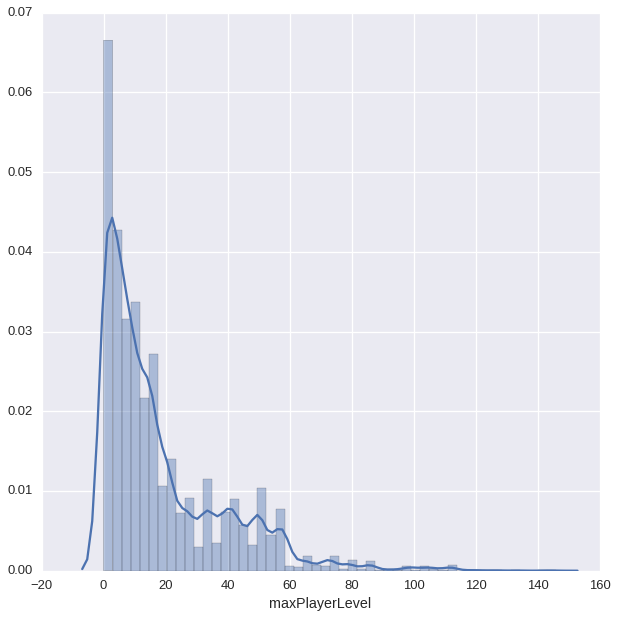

In [6]:
# сам по себе макслевел выглядит хуевенько

_ = xytte["maxPlayerLevel"]
s = sns.distplot(_)
#_.describe()

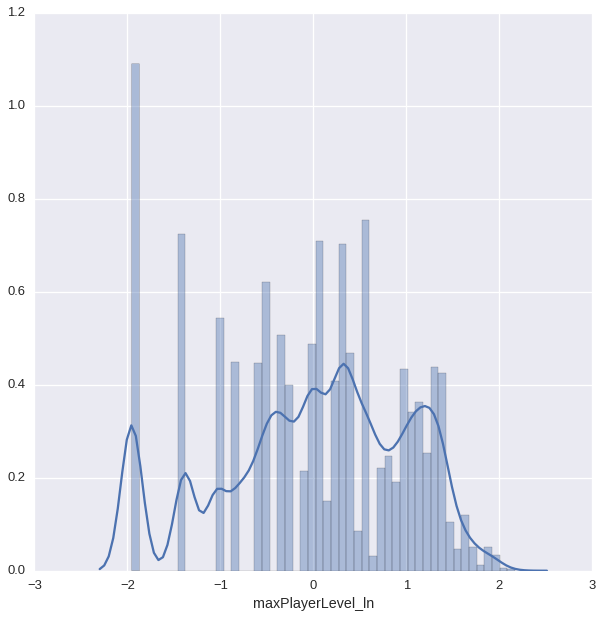

In [7]:
# поэтому слогарифмируем и отнормализуем его
xytte["maxPlayerLevel_ln"] = xytte["maxPlayerLevel"].apply(lambda x: np.log(x+1))
s = sns.distplot(norm(xytte["maxPlayerLevel_ln"]))
# лукс чуть пижже

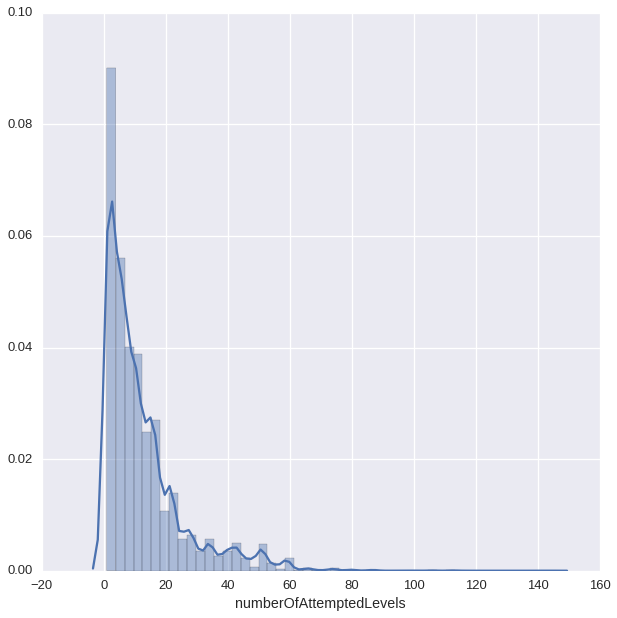

In [8]:
# второй параметр - numberOfAttemptedLevels
# выглядит он тоже не очень

sns.distplot(xytte["numberOfAttemptedLevels"])

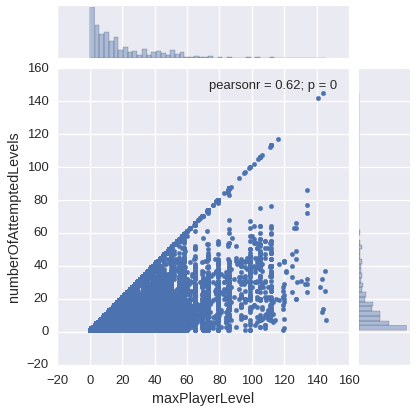

In [9]:
# проверим, зависит ли он как-то от первого

sns.jointplot(x="maxPlayerLevel", y="numberOfAttemptedLevels", data=xytte)

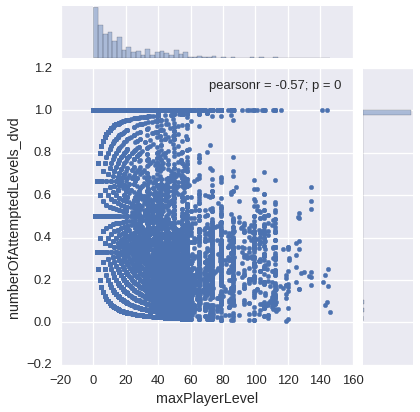

In [10]:
# оказывается, да
# может, поделить его на макслевел?

xytte["numberOfAttemptedLevels_dvd"] = (xytte["numberOfAttemptedLevels"]) / (xytte["maxPlayerLevel"] + 1)
#numberOfAttemptedLevels_dvd.columns = ["numberOfAttemptedLevels_dvd"]
sns.jointplot(x="maxPlayerLevel", y="numberOfAttemptedLevels_dvd", data=xytte)
#s = sns.distplot(norm(numberOfAttemptedLevels_dvd))
#numberOfAttemptedLevels_dvd
#xytt

maxPlayerLevel                        11305
numberOfAttemptedLevels               11305
attemptsOnTheHighestLevel             11305
totalNumOfAttempts                    11305
averageNumOfTurnsPerCompletedLevel    11305
doReturnOnLowerLevels                 11305
numberOfBoostersUsed                  11305
fractionOfUsefullBoosters             11305
totalScore                            11305
totalBonusScore                       11305
totalStarsCount                       11305
numberOfDaysActuallyPlayed            11305
returned                               5662
maxPlayerLevel_ln                     11305
numberOfAttemptedLevels_dvd           11305
dtype: int64

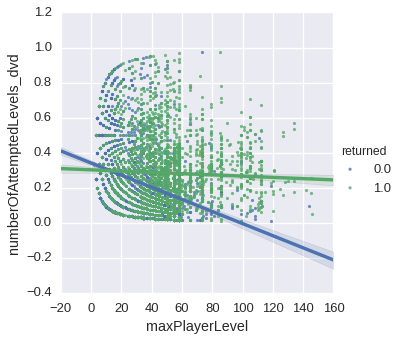

In [11]:
# первая группа людей - у которых количество попыток больше, чем максимальный уровень, причем ровно на один
# их 38 тысяч, и на них очевидно нужен какой-нибудь булевый столбец
# проверим, убрав из графика людей с нулевым макслевелом
cut = xytte[xytte["maxPlayerLevel"] > xytte["numberOfAttemptedLevels"]]
s = sns.lmplot(x="maxPlayerLevel", y="numberOfAttemptedLevels_dvd", 
           data=cut, hue="returned", fit_reg=True, scatter_kws={"s": 10}, size=5)
#s.show()
cut.count()
#_ = (cut3 - 1) * 2**(xytt["numberOfAttemptedLevels"]/50) + 1
#sns.jointplot(x=xytt["numberOfAttemptedLevels"], y=_)

In [12]:
# ебанем два булевых столбца
xytte["attLevelsMoreThanMaxLevel"] = (xytte["numberOfAttemptedLevels"] > xytte["maxPlayerLevel"]) * 1.0
xytte["attLevelsLessThanMaxLevel"] = (xytte["numberOfAttemptedLevels"] <= xytte["maxPlayerLevel"]) * 1.0

count    50578.000000
mean         3.441971
std          6.643427
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        365.000000
Name: attemptsOnTheHighestLevel, dtype: float64

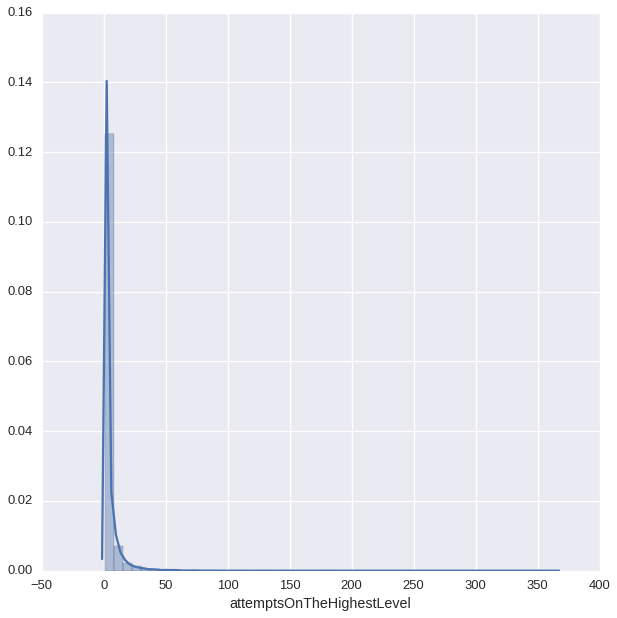

In [13]:
# едем дальше - attemptsOnTheHighestLevel

sns.distplot(xytte["attemptsOnTheHighestLevel"])
xytte["attemptsOnTheHighestLevel"].describe()

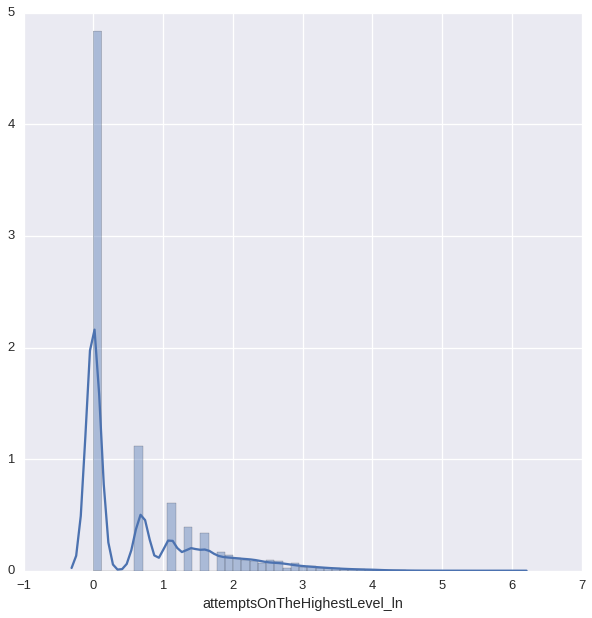

In [14]:
# ну понятно, все пробуют по одному разу, 75% не больше трех, а один еблан пробовал аж 365
# по этому распределению снова плачет логарифм

xytte["attemptsOnTheHighestLevel_ln"] = np.log(xytte["attemptsOnTheHighestLevel"])
sns.distplot(xytte["attemptsOnTheHighestLevel_ln"])

In [15]:
# кроме того, интересно посмотреть корреляцию с прошлыми столбцами
xytte[["attemptsOnTheHighestLevel_ln", "numberOfAttemptedLevels_dvd", "maxPlayerLevel_ln"]].corr()

attemptsOnTheHighestLevel_ln  \
attemptsOnTheHighestLevel_ln                      1.000000   
numberOfAttemptedLevels_dvd                      -0.316731   
maxPlayerLevel_ln                                 0.583839   

                              numberOfAttemptedLevels_dvd  maxPlayerLevel_ln  
attemptsOnTheHighestLevel_ln                    -0.316731           0.583839  
numberOfAttemptedLevels_dvd                      1.000000          -0.498289  
maxPlayerLevel_ln                               -0.498289           1.000000

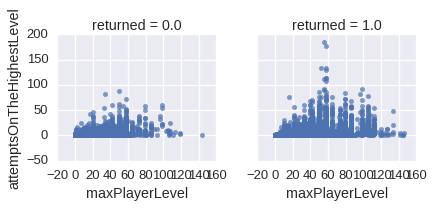

In [16]:
# есть с максуровнем, надо построить гистограммку и посмотреть, что почем

#sns.lmplot(x="maxPlayerLevel", y="attemptsOnTheHighestLevel", data=xytte, hue="returned", fit_reg=False, scatter_kws={"s": 10})
g = sns.FacetGrid(xytte, col="returned")
g.map(plt.scatter, "maxPlayerLevel", "attemptsOnTheHighestLevel", alpha=.7)
g.add_legend();

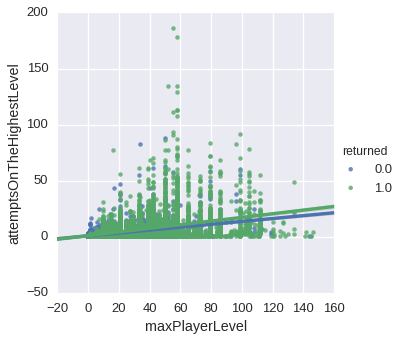

In [17]:
# нихуя не вижу

sns.lmplot(x="maxPlayerLevel", y="attemptsOnTheHighestLevel", data=xytte, hue="returned", fit_reg=True)

In [18]:
# и даже фитовочные линии для вернувшихся и нет одни и те же
# в пизду, нормируем и дальше идем
# можно попробовать ввести столбец на "пробовал не больше трех раз", но хз, потом попробую

count    50578.000000
mean        26.714323
std         39.689899
min          1.000000
25%          4.000000
50%         12.000000
75%         31.000000
max        563.000000
Name: totalNumOfAttempts, dtype: float64

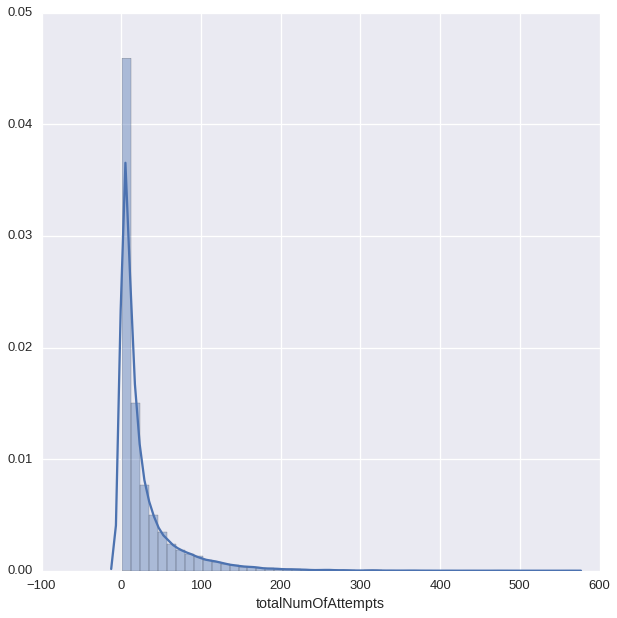

In [19]:
# теперь totalNumOfAttempts

sns.distplot(xytte["totalNumOfAttempts"])
xytte["totalNumOfAttempts"].describe()

attemptsOnTheHighestLevel_ln  \
attemptsOnTheHighestLevel_ln                      1.000000   
numberOfAttemptedLevels_dvd                      -0.316731   
maxPlayerLevel_ln                                 0.583839   
totalNumOfAttempts_ln                             0.619068   

                              numberOfAttemptedLevels_dvd  maxPlayerLevel_ln  \
attemptsOnTheHighestLevel_ln                    -0.316731           0.583839   
numberOfAttemptedLevels_dvd                      1.000000          -0.498289   
maxPlayerLevel_ln                               -0.498289           1.000000   
totalNumOfAttempts_ln                           -0.106861           0.873696   

                              totalNumOfAttempts_ln  
attemptsOnTheHighestLevel_ln               0.619068  
numberOfAttemptedLevels_dvd               -0.106861  
maxPlayerLevel_ln                          0.873696  
totalNumOfAttempts_ln                      1.000000

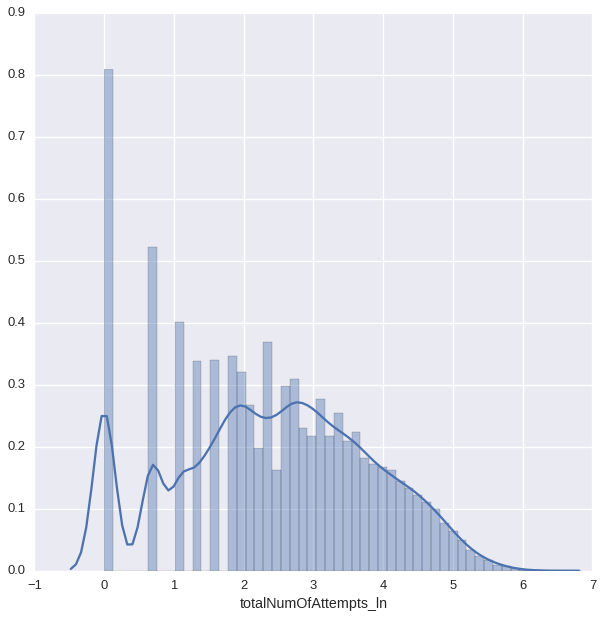

In [20]:
# те же яйца
# логарифм и корреляции

xytte["totalNumOfAttempts_ln"] = np.log(xytte["totalNumOfAttempts"])
sns.distplot(xytte["totalNumOfAttempts_ln"])
xytte[["attemptsOnTheHighestLevel_ln", "numberOfAttemptedLevels_dvd", "maxPlayerLevel_ln", "totalNumOfAttempts_ln"]].corr()

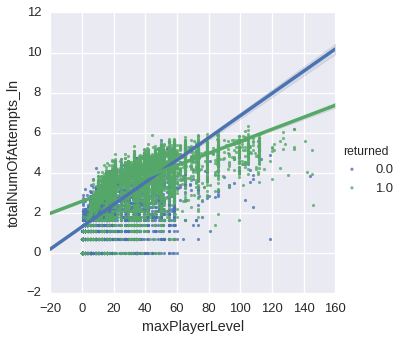

In [21]:
# 0.6 и 0.8, охуеть
# но логарифм хорошо отработал

sns.lmplot(x="maxPlayerLevel", y="totalNumOfAttempts_ln", 
           data=xytte, hue="returned", fit_reg=True, scatter_kws={"s": 10})

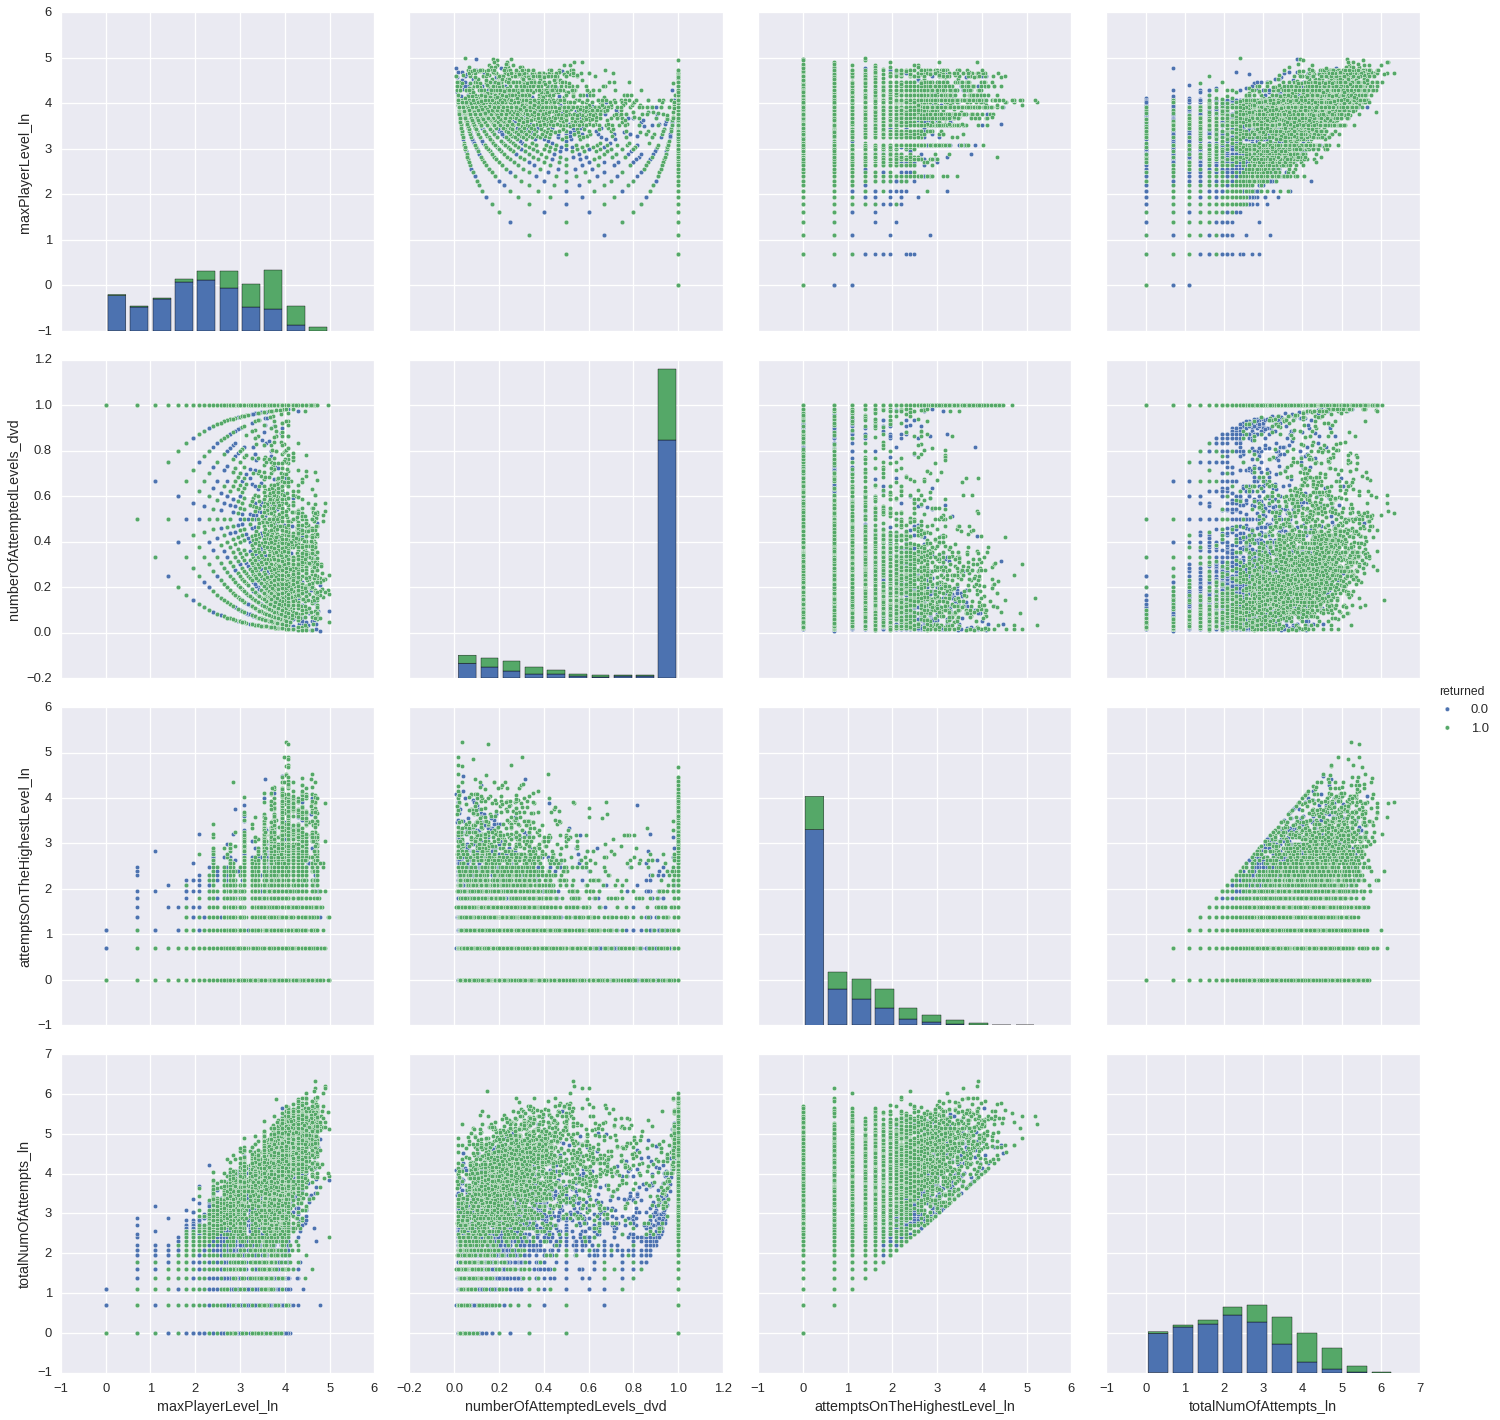

In [22]:
# а что если визуализировать все четыре штуки пока

sns.pairplot(xytte, vars=["maxPlayerLevel_ln",
                          "numberOfAttemptedLevels_dvd",
                          "attemptsOnTheHighestLevel_ln",
                          "totalNumOfAttempts_ln"], hue="returned", size=5)

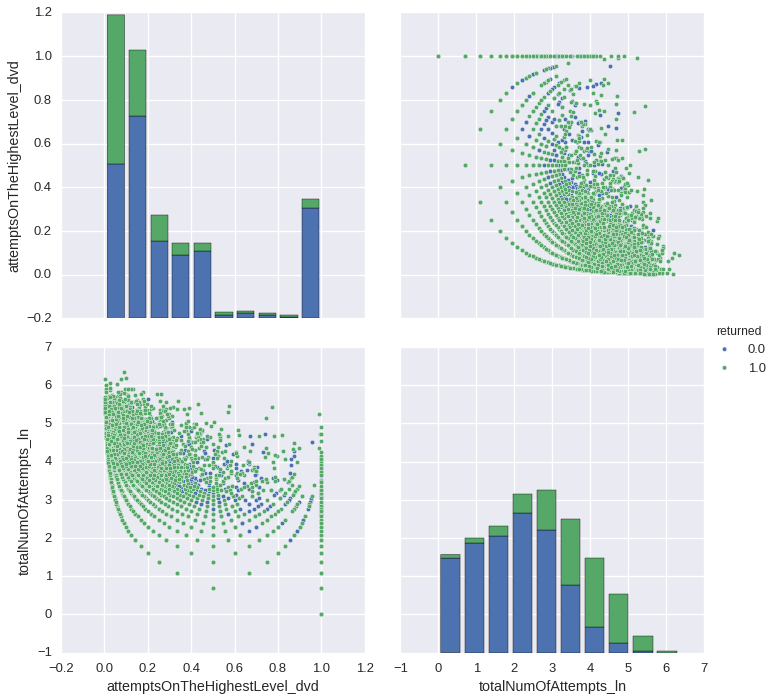

In [43]:
# найс
# кстати, число попыток на хайест левеле надо бы поделить на общее число попыток
# получим график поровнее и процент попыток на маклевеле

# вообще мне пришла в голову идея, что надо избавляться от корреляций
# это в некотором смысле ортогонализация входных данных, результат от этого должен только выиграть
# но это буду делать массово потом, наверное

xytte["attemptsOnTheHighestLevel_dvd"] = (xytte["attemptsOnTheHighestLevel"]) / (xytte["totalNumOfAttempts"] + 0)

sns.pairplot(xytte, vars=["attemptsOnTheHighestLevel_dvd",
                          "totalNumOfAttempts_ln"], hue="returned", size=5)

In [24]:
# выглядит поинтереснее
# добавим булев столбец для чуваков со ста процентами, больно их много
# а логарифмировать не будем, и так сойдет

xytte["allAttemptsOnTheHighestLevel"] = (xytte["attemptsOnTheHighestLevel"] == xytte["totalNumOfAttempts"]) * 1.0

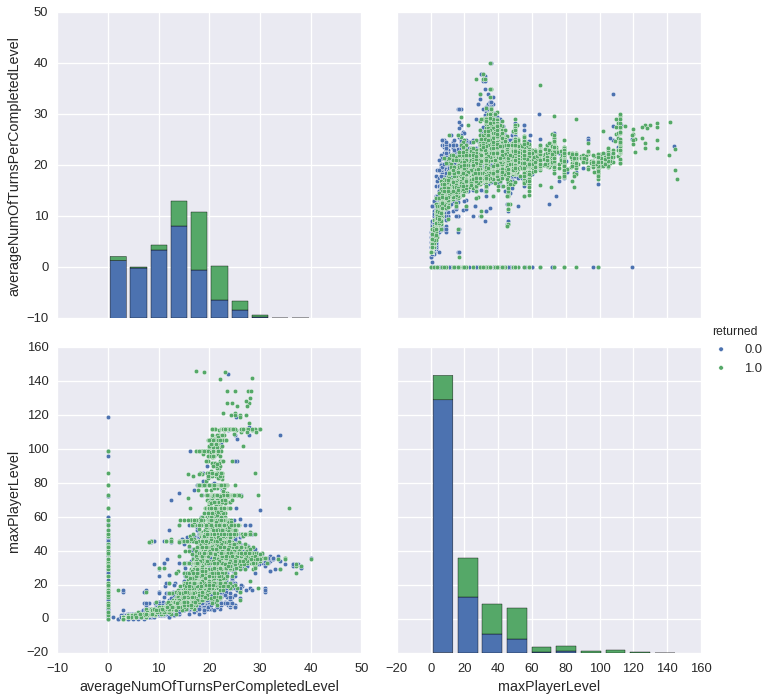

In [25]:
# averageNumOfTurnsPerCompletedLevel - показатель тупизны

sns.pairplot(xytte, vars=["averageNumOfTurnsPerCompletedLevel",
                          "maxPlayerLevel"], hue="returned", size=5)

In [46]:
# во-первых, чуваки с нулем отправляются в булев ад
# их 1266
xytte["zeroTurnsPerCompletedLevel"] = (xytte["averageNumOfTurnsPerCompletedLevel"] == 0) * 1.0

# во-вторых, наблюдается какая-то корреляция с макслевелом
xytte[["averageNumOfTurnsPerCompletedLevel", "maxPlayerLevel"]].corr()

averageNumOfTurnsPerCompletedLevel  \
averageNumOfTurnsPerCompletedLevel                            1.000000   
maxPlayerLevel                                                0.684409   

                                    maxPlayerLevel  
averageNumOfTurnsPerCompletedLevel        0.684409  
maxPlayerLevel                            1.000000

averageNumOfTurnsPerCompletedLevel_dvd  \
averageNumOfTurnsPerCompletedLevel_dvd                                 1.00000   
maxPlayerLevel                                                         0.46855   

                                        maxPlayerLevel  
averageNumOfTurnsPerCompletedLevel_dvd         0.46855  
maxPlayerLevel                                 1.00000

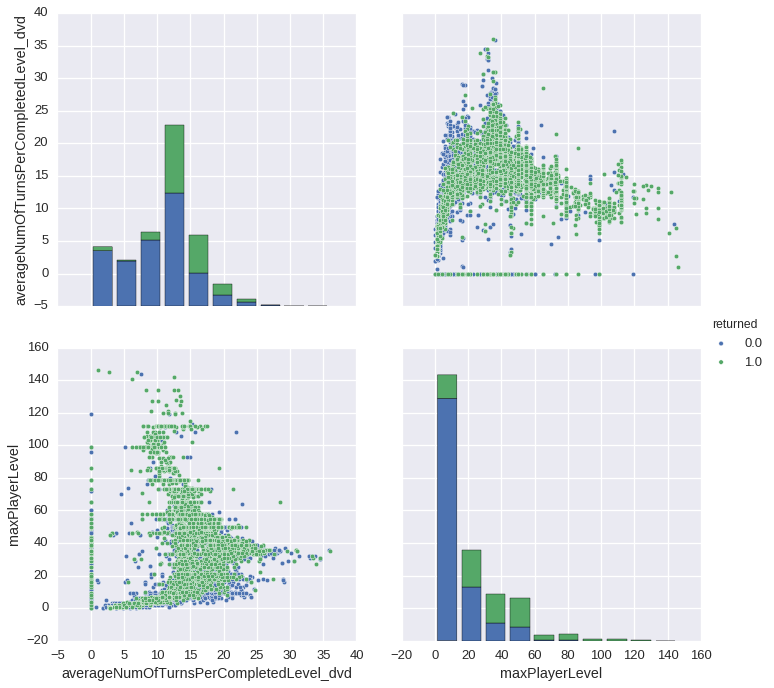

In [47]:
# возможно, стоит поделить одно на другое

xytte["averageNumOfTurnsPerCompletedLevel_dvd"] = (xytte["averageNumOfTurnsPerCompletedLevel"] \
                                                - (xytte["maxPlayerLevel"] + 1) / 9) \
                                                * (1 - xytte["zeroTurnsPerCompletedLevel"])
#for i, v in enumerate(cut["zeroTurnsPerCompletedLevel"]):
#    if not v:
#        cut["averageNumOfTurnsPerCompletedLevel_div"][i] = 0 
sns.pairplot(xytte, vars=["averageNumOfTurnsPerCompletedLevel_dvd",
                          "maxPlayerLevel"], hue="returned", size=5)
xytte[["averageNumOfTurnsPerCompletedLevel_dvd", "maxPlayerLevel"]].corr()


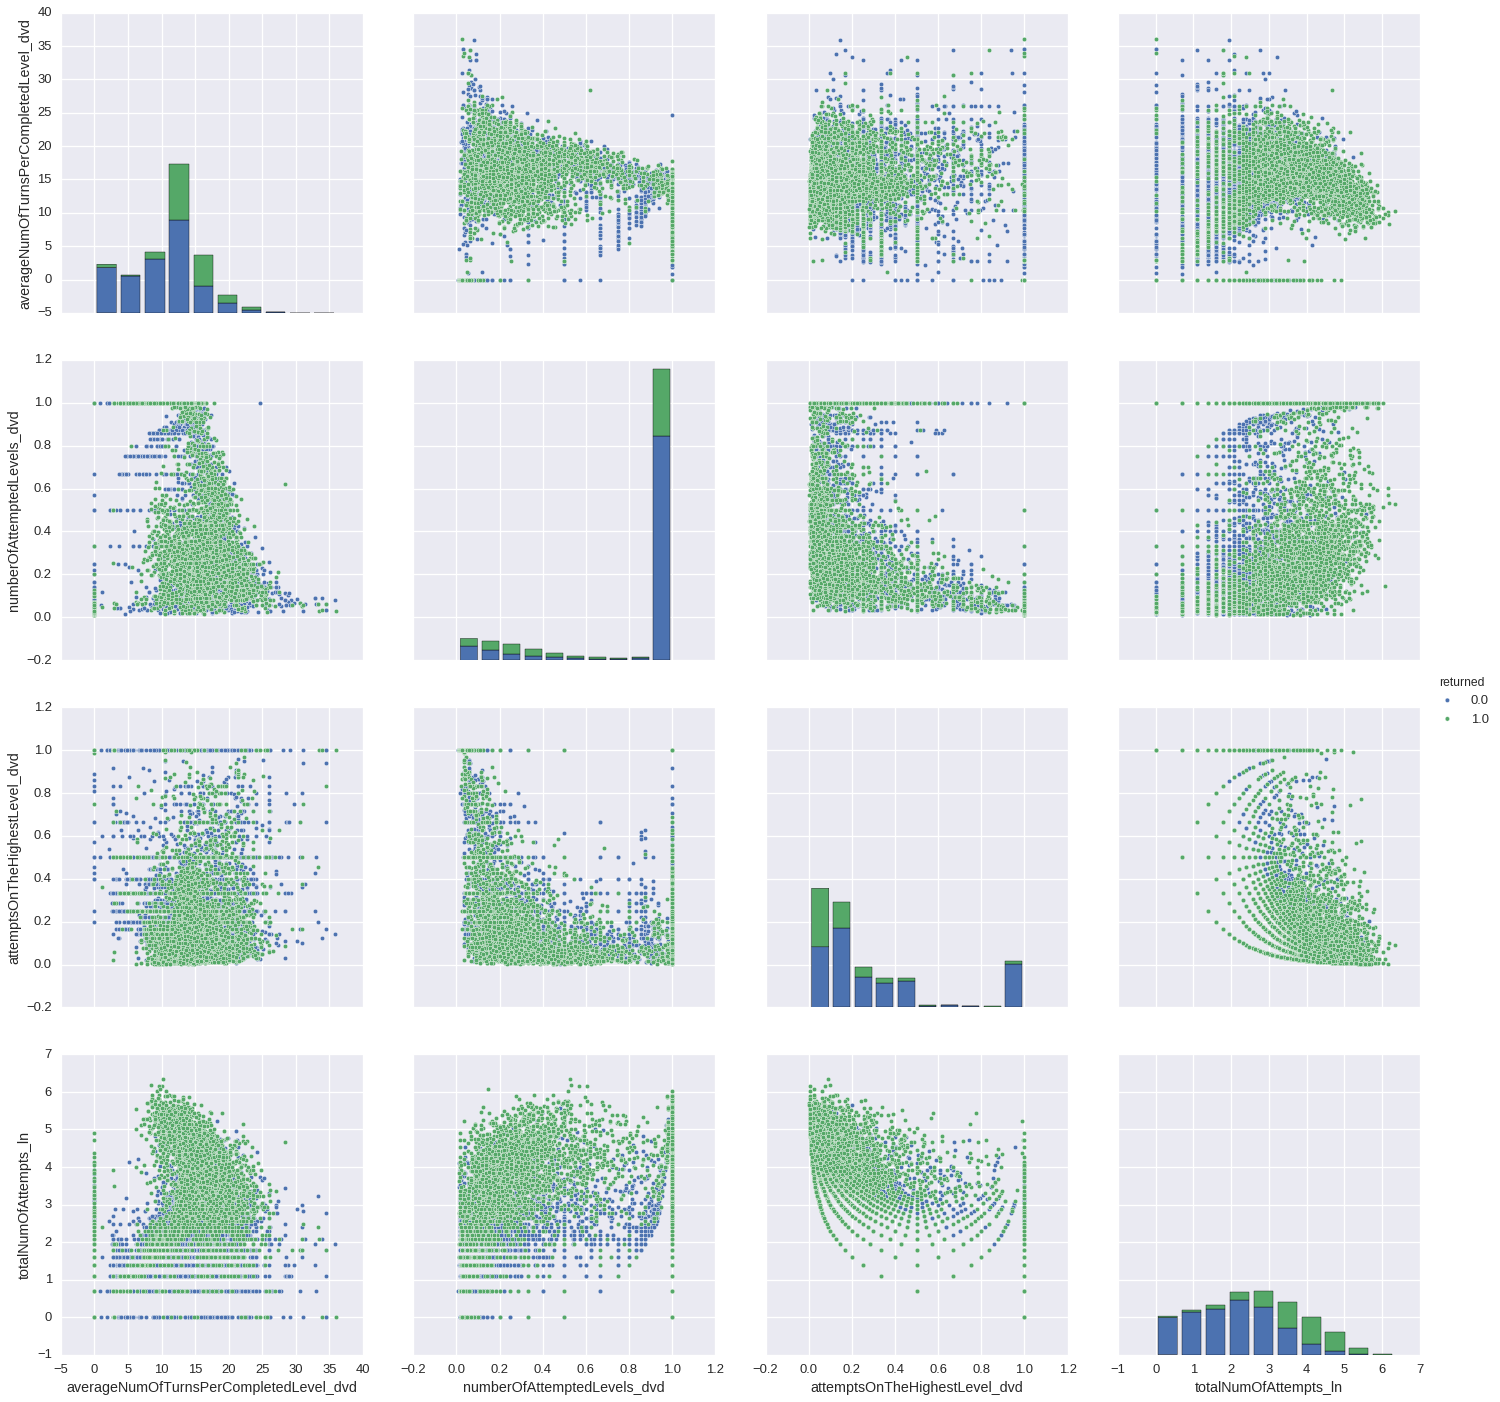

In [48]:
# вроде симпатичнее
# посмотрим на остальные плоты

sns.pairplot(xytte, vars=["averageNumOfTurnsPerCompletedLevel_dvd",
                          "numberOfAttemptedLevels_dvd",
                          "attemptsOnTheHighestLevel_dvd",
                          "totalNumOfAttempts_ln"], hue="returned", size=5)

In [50]:
""" 
нормуль
итого из пяти колонок

'maxPlayerLevel',
'numberOfAttemptedLevels',
'attemptsOnTheHighestLevel',
'totalNumOfAttempts',
'averageNumOfTurnsPerCompletedLevel'

получилось еще 11

'maxPlayerLevel_ln',
'numberOfAttemptedLevels_dvd',
'attLevelsMoreThanMaxLevel',
'attLevelsLessThanMaxLevel',
'attemptsOnTheHighestLevel_ln',
'totalNumOfAttempts_ln',
'attemptsOnTheHighestLevel_div',
'allAttemptsOnTheHighestLevel',
'zeroTurnsPerCompletedLevel',
'attemptsOnTheHighestLevel_dvd',
'averageNumOfTurnsPerCompletedLevel_dvd'

отлично, работаем дальше """

" \nнормуль\nитого из пяти колонок\n\n'maxPlayerLevel',\n'numberOfAttemptedLevels',\n'attemptsOnTheHighestLevel',\n'totalNumOfAttempts',\n'averageNumOfTurnsPerCompletedLevel'\n\nполучилось еще 11\n\n'maxPlayerLevel_ln',\n'numberOfAttemptedLevels_dvd',\n'attLevelsMoreThanMaxLevel',\n'attLevelsLessThanMaxLevel',\n'attemptsOnTheHighestLevel_ln',\n'totalNumOfAttempts_ln',\n'attemptsOnTheHighestLevel_div',\n'allAttemptsOnTheHighestLevel',\n'zeroTurnsPerCompletedLevel',\n'attemptsOnTheHighestLevel_dvd',\n'averageNumOfTurnsPerCompletedLevel_dvd'\n\nотлично, работаем дальше "

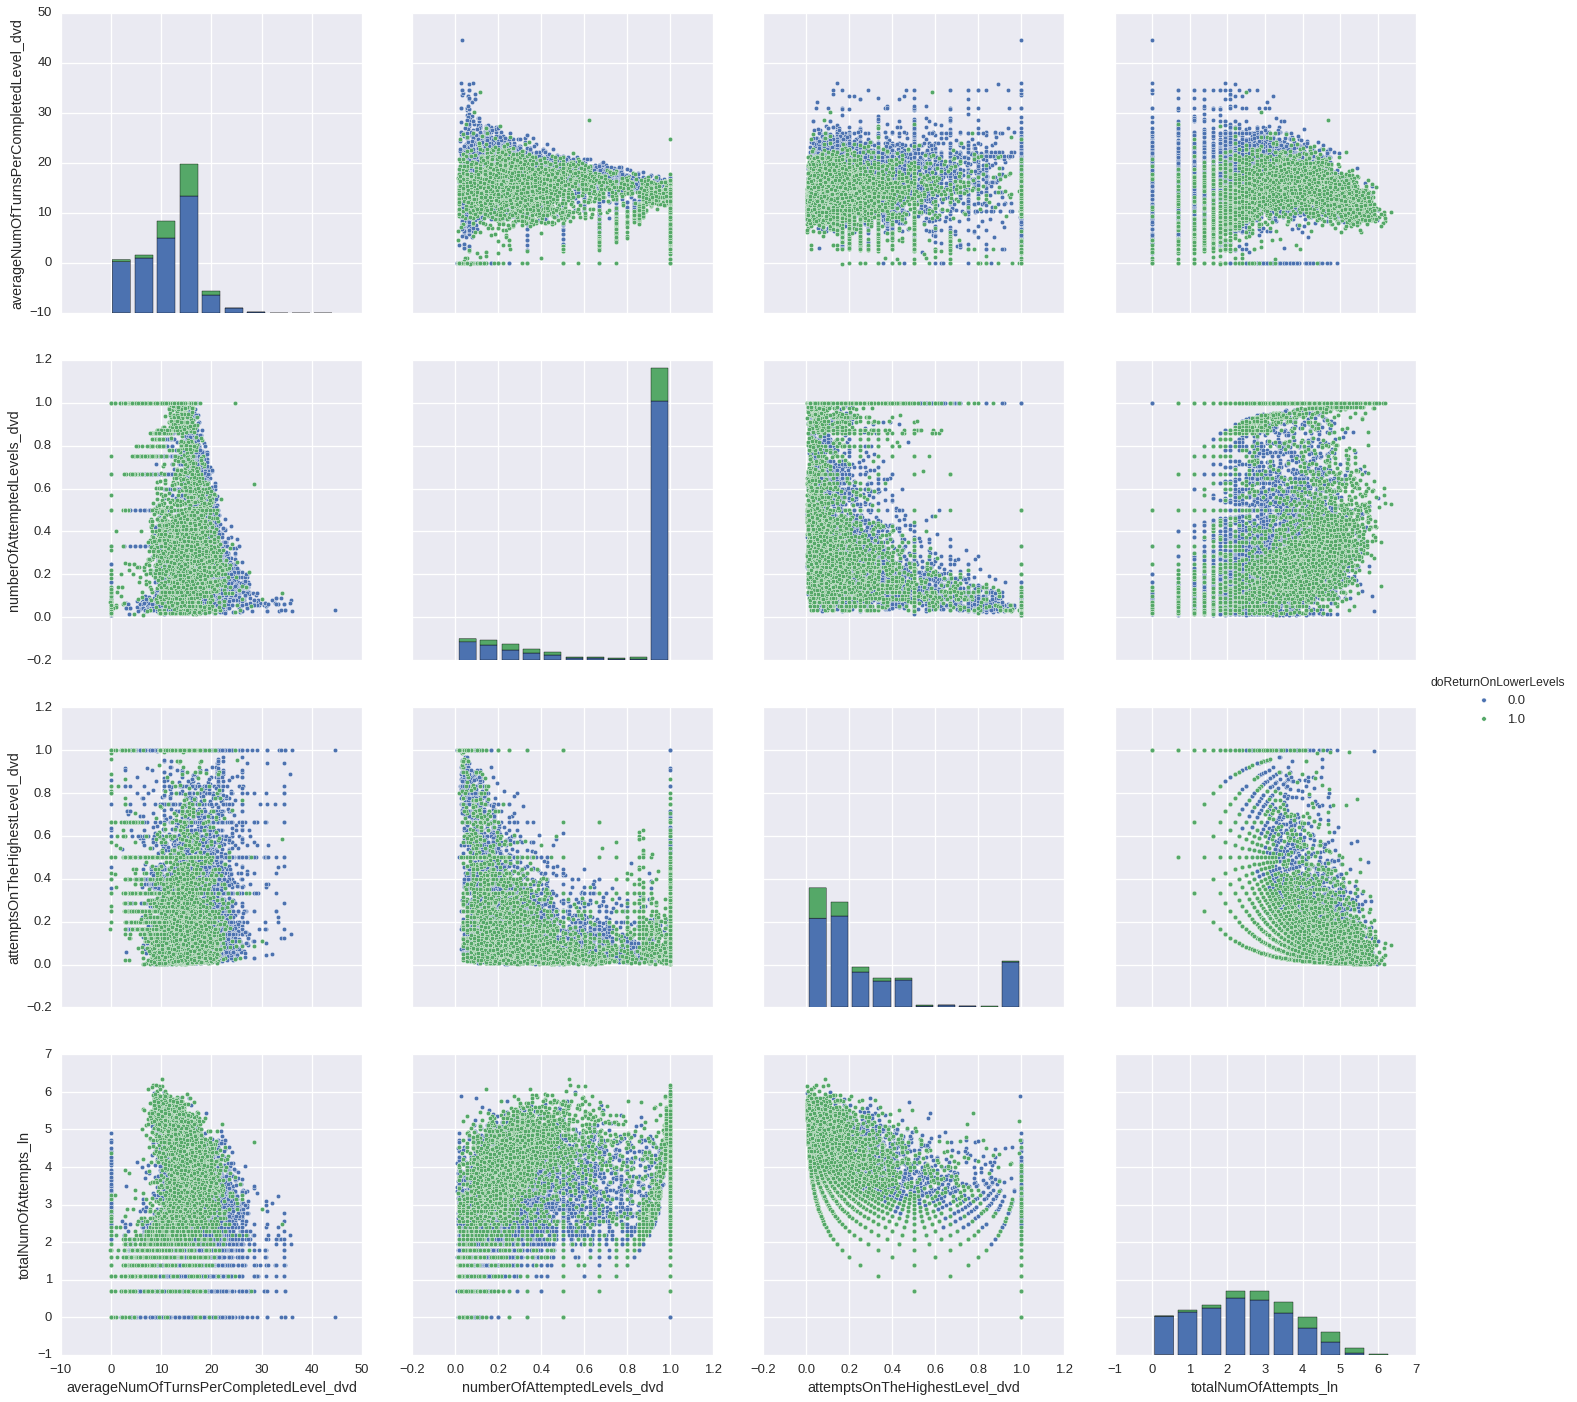

In [53]:
# следующая колонка - doReturnOnLowerLevels
# сама по себе булева, хуй с ней че сделаешь
# можно посмотреть на раскрасочки

sns.pairplot(xytte, vars=["averageNumOfTurnsPerCompletedLevel_dvd",
                          "numberOfAttemptedLevels_dvd",
                          "attemptsOnTheHighestLevel_dvd",
                          "totalNumOfAttempts_ln"], 
             hue="doReturnOnLowerLevels", size=5)

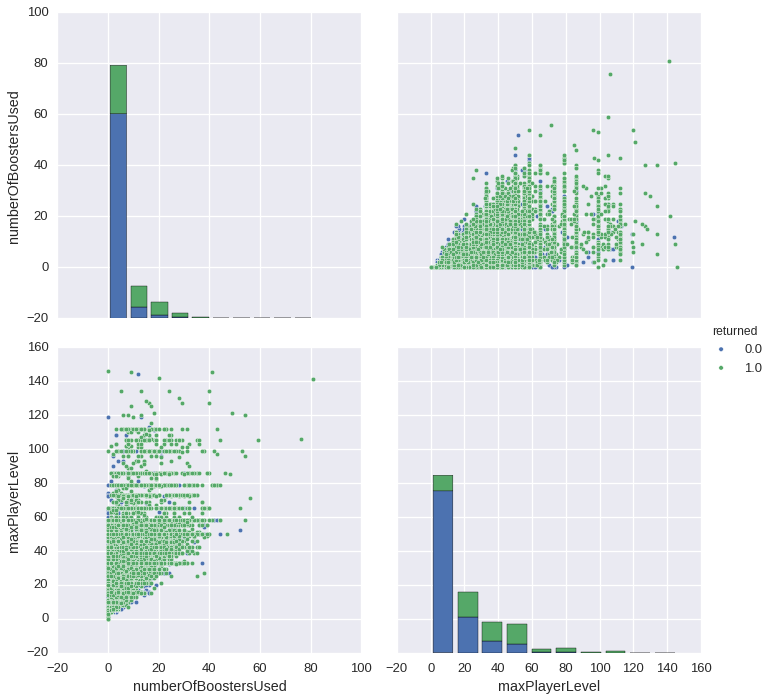

In [56]:
# и даже особо ни с кем не коррелирует
# и хуй с ней
# numberOfBoostersUsed

sns.pairplot(xytte, vars=["numberOfBoostersUsed",
                          "maxPlayerLevel"], hue="returned", size=5)

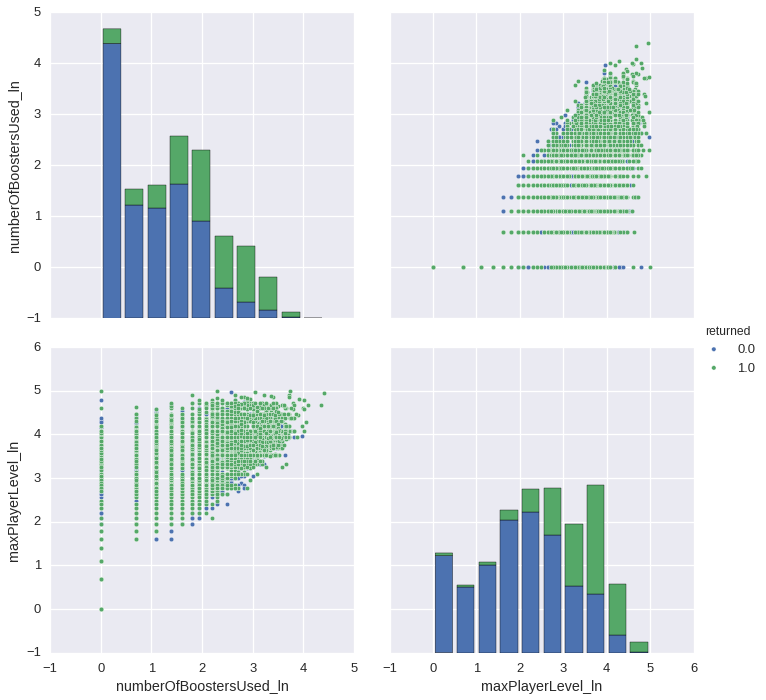

In [58]:
# по бустерам плачет логарифм

xytte["numberOfBoostersUsed_ln"] = xytte["numberOfBoostersUsed"].apply(lambda x: np.log(x+1))
sns.pairplot(xytte, vars=["numberOfBoostersUsed_ln",
                          "maxPlayerLevel_ln"], hue="returned", size=5)

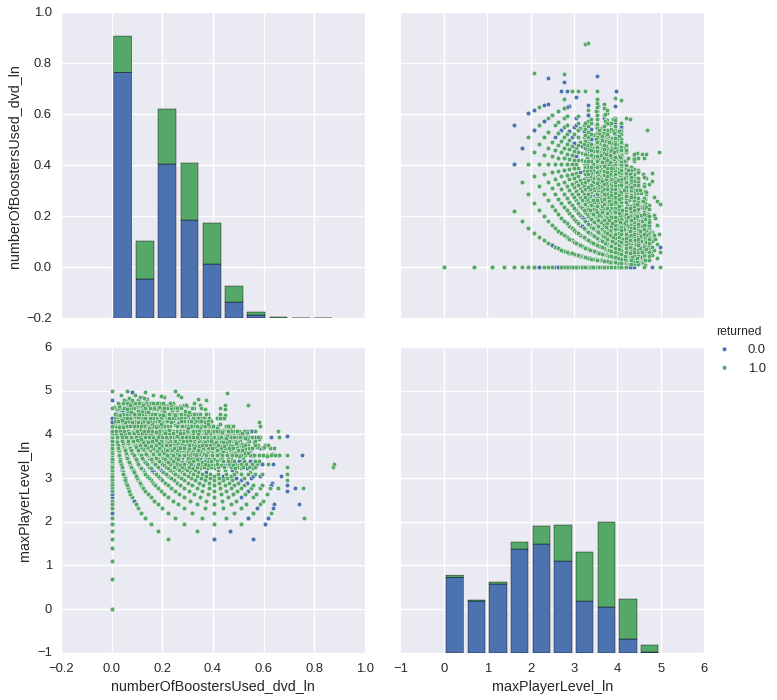

In [62]:
# стало получше
# тем не менее, можно заметить, что график черезчур линеен, кол-во бустеров почти всегда меньше левела
# поделим и посмотрим

xytte["numberOfBoostersUsed_dvd"] = xytte["numberOfBoostersUsed"] / (xytte["maxPlayerLevel"] + 0.01)
xytte["numberOfBoostersUsed_dvd_ln"] = xytte["numberOfBoostersUsed_dvd"].apply(lambda x: np.log(x+1))
sns.pairplot(xytte, vars=["numberOfBoostersUsed_dvd_ln",
                          "maxPlayerLevel_ln"], hue="returned", size=5)

1.4068863

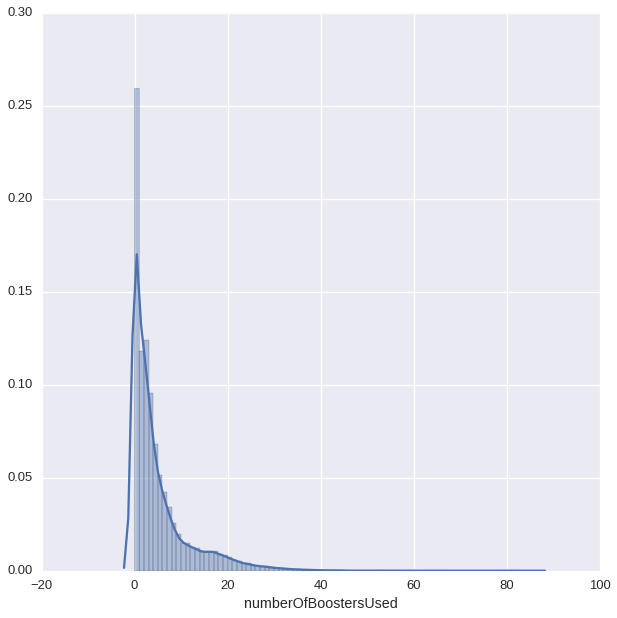

In [76]:
# не уверен, что нужен буль для чуваков без бустера
# не вижу ступеньки
sns.distplot(xytte["numberOfBoostersUsed"], bins=86)
xytte["numberOfBoostersUsed_dvd"].max()

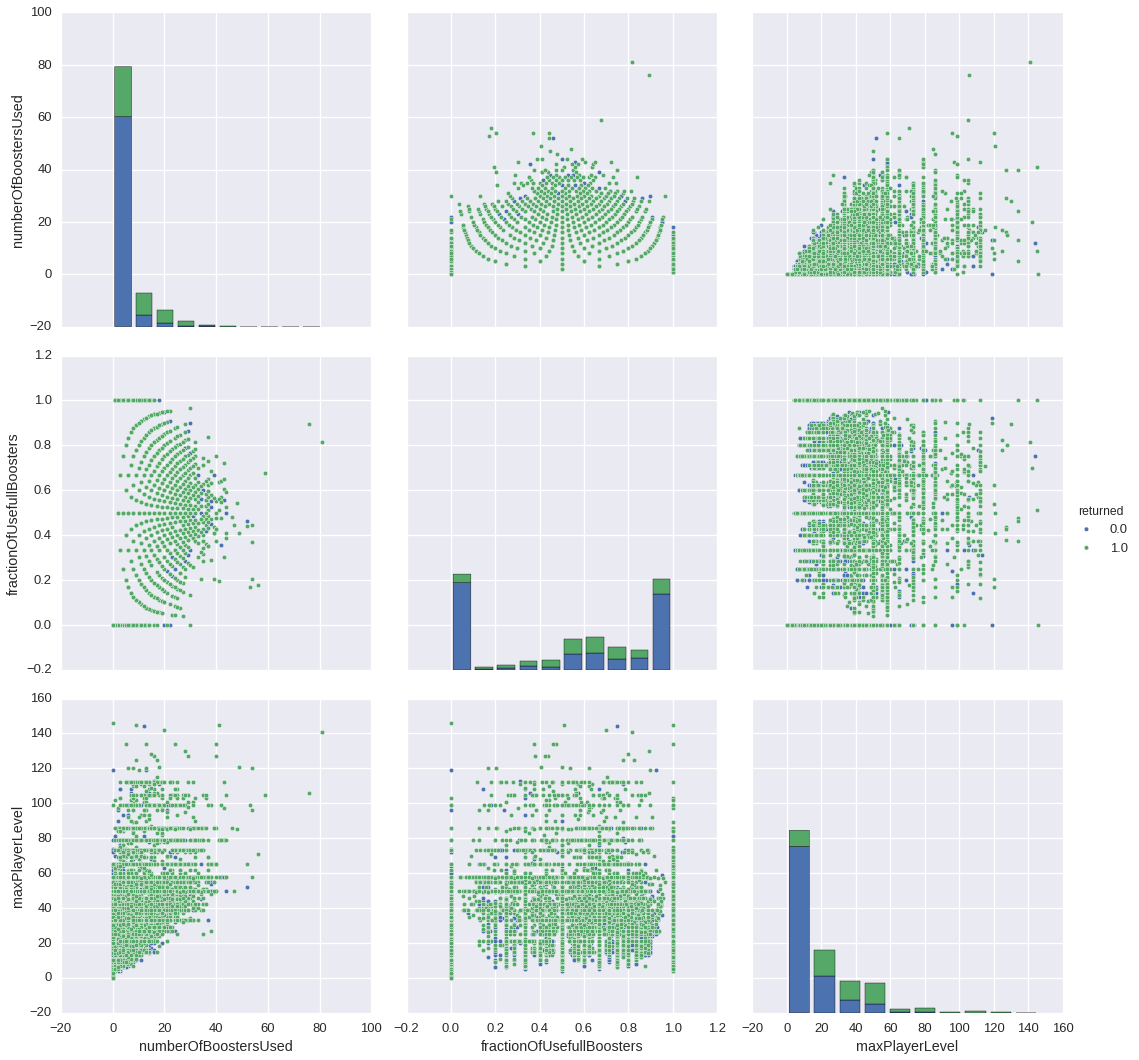

In [78]:
# fractionOfUsefullBoosters

sns.pairplot(xytte, vars=["numberOfBoostersUsed",
                          "fractionOfUsefullBoosters",
                          "maxPlayerLevel"], hue="returned", size=5)

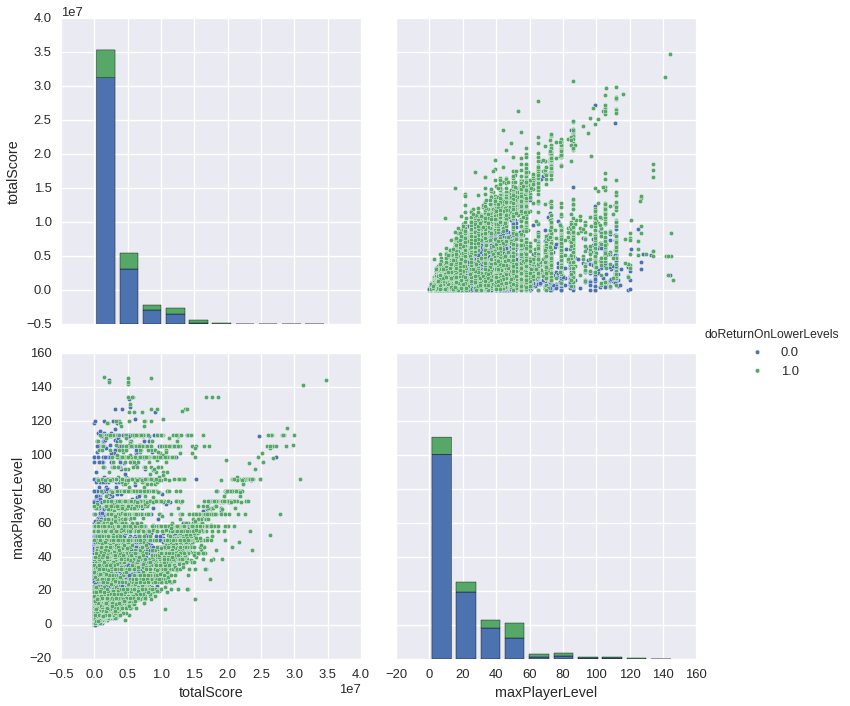

In [80]:
# меня устраивает
# totalScore
# окраска в вернувшихся на нижние уровни, должно быть более релевантно
sns.pairplot(xytte, vars=["totalScore", "maxPlayerLevel"], hue="doReturnOnLowerLevels", size=5)

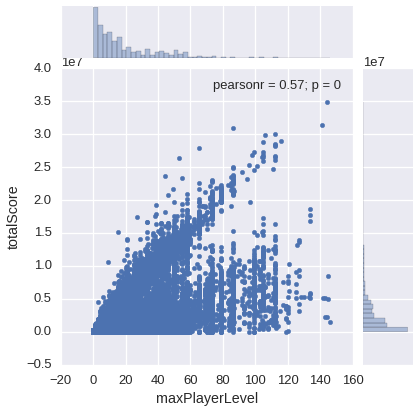

In [92]:
# и к вопросу о том, зачем нужны логарифмы
# на графике кажется, что половина точек накидана плеерлевеле от 1 до 60
# а реально от 1 до 10
sns.jointplot(x="maxPlayerLevel", y="totalScore", data=xytte)


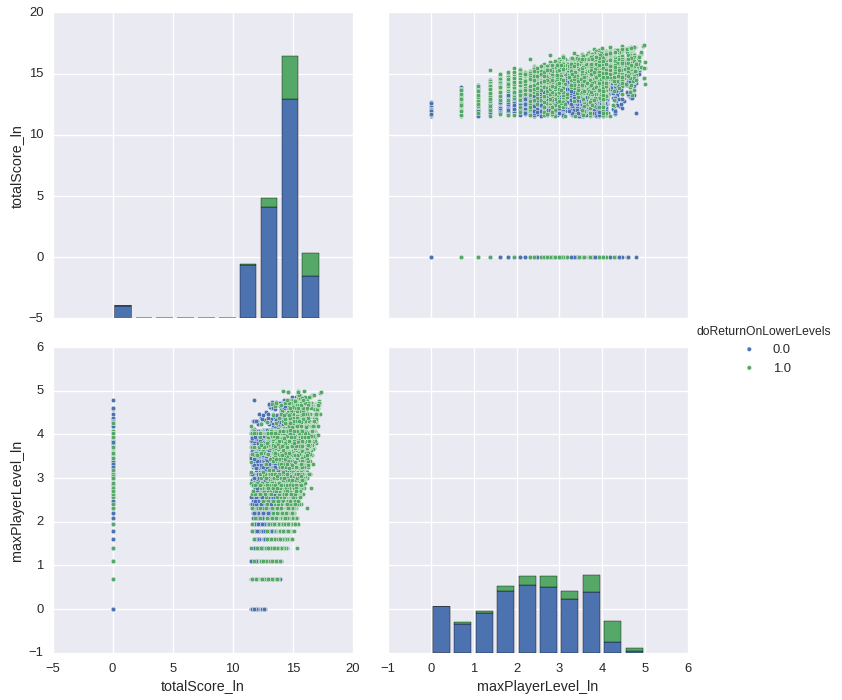

In [93]:
xytte["totalScore_ln"] = xytte["totalScore"].apply(lambda x: np.log(x+1))
sns.pairplot(xytte, vars=["totalScore_ln", "maxPlayerLevel_ln"], hue="doReturnOnLowerLevels", size=5)

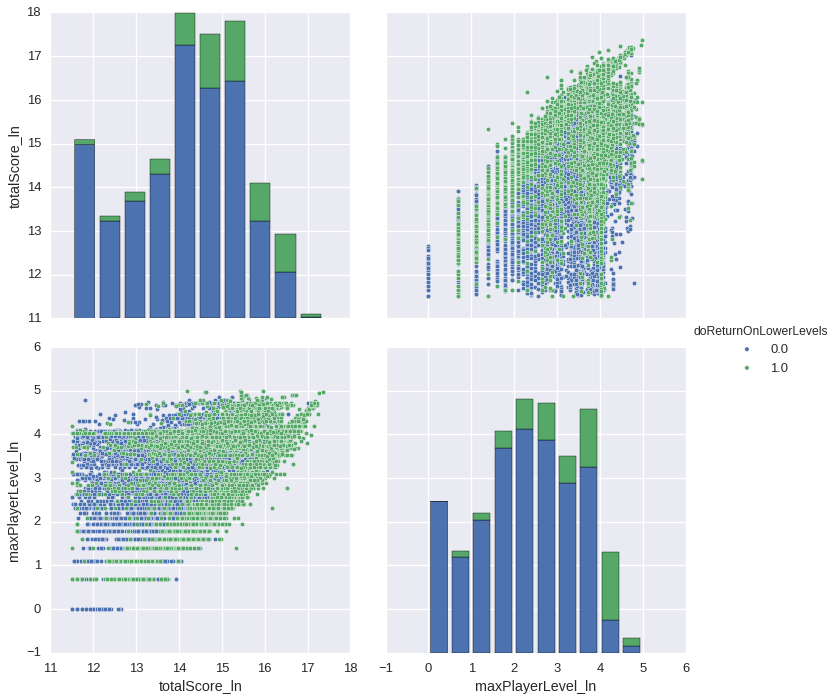

In [94]:
# уродливо выглядят чуваки с нулевым тоталскором, обрежем их
cut = xytte[xytte["totalScore_ln"] > 0]

sns.pairplot(cut, vars=["totalScore_ln", "maxPlayerLevel_ln"], hue="doReturnOnLowerLevels", size=5)


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


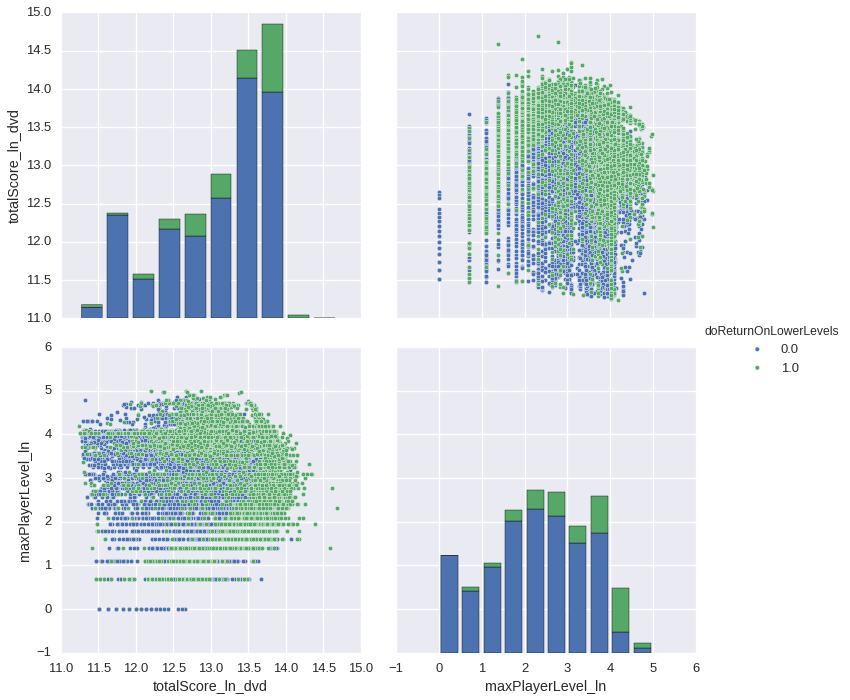

In [102]:
# попробуем отнять макслевел для более ровной картинки

cut["totalScore_ln_dvd"] = cut["totalScore_ln"] - (cut["totalScore_ln"] - 11) * cut["maxPlayerLevel_ln"] / 8
sns.pairplot(cut, vars=["totalScore_ln_dvd", "maxPlayerLevel_ln"], hue="doReturnOnLowerLevels", size=5)


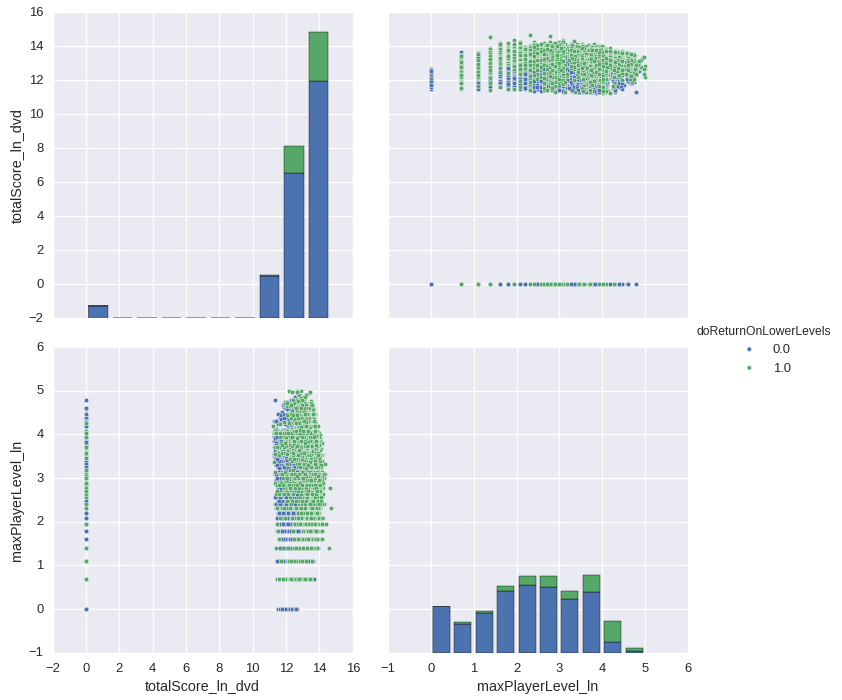

In [104]:
# осталась проблема с выколотыми значениями

xytte["totalScore_ln_dvd"] = (xytte["totalScore_ln"] > 0) * \
                             (xytte["totalScore_ln"] - \
                             (xytte["totalScore_ln"] - 11) * xytte["maxPlayerLevel_ln"] / 8)
sns.pairplot(xytte, vars=["totalScore_ln_dvd", "maxPlayerLevel_ln"], hue="doReturnOnLowerLevels", size=5)

In [ ]:
# чует мое сердце, надо их будет либо отдельной таблицей прогонять, либо булеву переменную херачить
# tbd

